In [1]:
# %load runSA1SA2.py
import ggcnn.experiment as experiment
import sys
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold


def load_sa1_dataset():
    keys_SA1 = []
    features_SA1 = []
    labels = []
    keys_SA2 = []
    features_SA2 = []
    
    # Load SA1 Node Features
    with open('Data/2018-08-24-NSW-SA1Input-Normalised.csv', 'r') as file:
        for i, line in enumerate(file):
            if i == 0:  # Skip first line (header)
                continue
            s = line[:-1].split(',')  # Last value in line is \n
            keys_SA1.append(s[0])
            features_SA1.extend([float(v) for v in s[1:-1]])  # Last column is the outcome y
#             labels.append(np.floor(float(s[-1]) / 10).astype(int))
            labels.append(float(s[-1]))
    
    
    # Load SA2 Node Features
    with open('Data/2018-08-28-NSW-SA2Input-Normalised.csv', 'r') as file:
        for i, line in enumerate(file):
            if i == 0:  # Skip first line (header)
                continue
            s = line[:-1].split(',')  # Last value in line is \n
            keys_SA2.append(s[0])
            features_SA2.extend([float(v) for v in s[1:-1]])  # Last column is the outcome y

    labels = np.array(labels)
    features_SA1 = np.array(features_SA1).reshape((len(keys_SA1), -1))
    features_SA2 = np.array(features_SA2).reshape((len(keys_SA2), -1))
    
    # Load SA1 Link Features
    with open('Data/2018-08-25-NSW-NeighbourDistance.csv', 'r') as file:
        adj_mat_SA1 = np.zeros((len(keys_SA1), len(keys_SA1)))
        for i, line in enumerate(file):
            if i == 0:  # Skip first line (header)
                continue
            s = line[:-1].split(',')
            a = keys_SA1.index(s[0])
            b = keys_SA1.index(s[1])
            adj_mat_SA1[a, b] = 1
            adj_mat_SA1[b, a] = 1
    

    # Load SA2 Link Features
    with open('Data/Geography/2018-08-28-NSW-SA2_Neighbouring_Suburbs_With_Bridges-GCC.csv', 'r') as file:
        adj_mat_SA2 = np.zeros((len(keys_SA2), len(keys_SA2)))
        for i, line in enumerate(file):
            if i == 0:  # Skip first line (header)
                continue
            s = line[:-1].split(',')
            a = keys_SA2.index(s[0])
            b = keys_SA2.index(s[1])
            adj_mat_SA2[a, b] = 1
            adj_mat_SA2[b, a] = 1
    
    
    # Load SA1, SA2 Links
    with open('Data/SA1SA2Links.csv', 'r') as file:
        adj_mat_SA1SA2 = np.zeros((len(keys_SA1), len(keys_SA2)))
        for i, line in enumerate(file):
            if i == 0:  # Skip first line (header)
                continue
            s = line[:-1].split(',')
            a = keys_SA1.index(s[0])
            b = keys_SA2.index(s[1])
            adj_mat_SA1SA2[a, b] = 1
    
    adj_mat_SA2SA1 = np.transpose(adj_mat_SA1SA2)
    
#     adj_mat_SA1SA2 = adj_mat_SA1SA2 / np.sum(adj_mat_SA1SA2, axis = -1, keepdims = True)
#     adj_mat_SA2SA1 = adj_mat_SA2SA1 / np.sum(adj_mat_SA2SA1, axis = -1, keepdims = True)
    
    return features_SA1, adj_mat_SA1, labels, features_SA2, adj_mat_SA2, adj_mat_SA1SA2, adj_mat_SA2SA1

dataset = load_sa1_dataset()

In [3]:
class SA1Experiment():
    def __init__(self, neurons, blocks):
        self.blocks = blocks
        self.neurons = neurons
    
    def create_network(self, net, input):
        net.create_network(input)
        
        net.make_reverse_auxilary_linkage_layer(None)
        net.make_linkage_adjustment_layer()
#         net.make_auxilary_linkage_layer(0, with_act_func = False)
        
        net.make_embedding_layer(self.neurons)
        net.make_dropout_layer()
        
        for _ in range(self.blocks):
            net.make_graphcnn_layer(self.neurons)
            net.make_dropout_layer()
            net.make_embedding_layer(self.neurons)
            net.make_dropout_layer()
        
#         net.make_auxilary_embedding_layer(self.neurons)
#         net.make_dropout_layer(input_type = 'current_V_auxilary')
#         net.make_reverse_auxilary_linkage_layer(None)
#         net.make_auxilary_embedding_layer(self.neurons)
#         net.make_dropout_layer(input_type = 'current_V_auxilary')
#         net.make_auxilary_graphcnn_layer(self.neurons)
#         net.make_dropout_layer(input_type = 'current_V_auxilary')
        net.make_auxilary_linkage_layer(None, with_act_func = False)
        
        net.make_embedding_layer(self.neurons)
        net.make_embedding_layer(1, name='final', with_bn=False, with_act_func = False)


no_folds = 5
inst = KFold(n_splits = no_folds, shuffle=True, random_state=125)

l = 2
n = 128
i = 4

    
exp = experiment.GGCNNExperiment('2018-08-28-SA1SA2', '2018-08-28-SA1SA2', SA1Experiment(neurons = n, blocks = l))


exp.num_iterations = 5000
exp.optimizer = 'adam'
exp.loss_type = 'linear'

exp.debug = True  # Was True

exp.preprocess_data(dataset)

# train_idx, test_idx = list(inst.split(np.arange(len(dataset[0]))))[i]
test_idx, train_idx = list(inst.split(np.arange(len(dataset[0]))))[i]  # Reversed to get more samples in the test set than the training set


exp.create_data(train_idx, test_idx)
exp.build_network()
results = exp.run()

2018-09-01 15:21:02.193291 Creating training Tensorflow Tensors
2018-09-01 15:21:02.346910 Creating training network
2018-09-01 15:21:06.921379 Creating loss function and summaries
2018-09-01 15:21:07.599717 Training model "2018-08-28-SA1SA2"!
2018-09-01 15:21:07.599796 Preparing training
2018-09-01 15:22:39.235753 Starting threads
2018-09-01 15:22:39.999635 Starting training. train_batch_size: 0 test_batch_size: 0
2018-09-01 15:22:46.933962 Test Step 0 Finished
2018-09-01 15:22:46.934050 Test Step 0 "min loss" =  3.5037126e+16
2018-09-01 15:22:46.934885 Test Step 0 "loss" =  3.5037126e+16
2018-09-01 15:22:52.416696 Training Step 0 Finished Timing (Training: 0.441472, Test: 0.558449) after 12.417 seconds
2018-09-01 15:22:52.416790 Training Step 0 "min loss" =  2859.3022
2018-09-01 15:22:52.416838 Training Step 0 "loss" =  2859.3022
2018-09-01 15:22:58.107375 Test Step 5 Finished
2018-09-01 15:22:58.107476 Test Step 5 "min loss" =  2764.6523
2018-09-01 15:22:58.107554 Test Step 5 "loss"

KeyboardInterrupt: 

In [46]:
train_df = pd.DataFrame(results[0])
test_df = pd.DataFrame(results[1])
test_df.set_index(test_df.index * exp.iterations_per_test, inplace = True)

In [ ]:
import matplotlib.pyplot as plt

train_df['accuracy'].plot()
test_df['accuracy'].plot()
plt.show()

In [ ]:
train_df['cross_entropy'].loc[10:].plot()
test_df['cross_entropy'].loc[10:].plot()

plt.show()

6.590785980224609


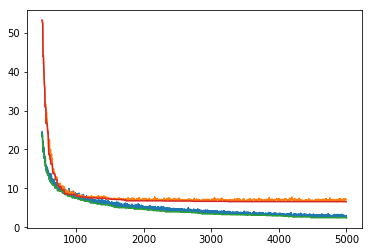

In [47]:
import matplotlib.pyplot as plt

train_df['loss'].loc[500:].plot()
test_df['loss'].loc[500:].plot()
train_df['min loss'].loc[500:].plot()
test_df['min loss'].loc[500:].plot()
print(test_df['min loss'].iloc[-1])

plt.show()

In [22]:
predictions = results[-1].ravel()[test_idx]
actual = dataset[2].ravel()[test_idx]

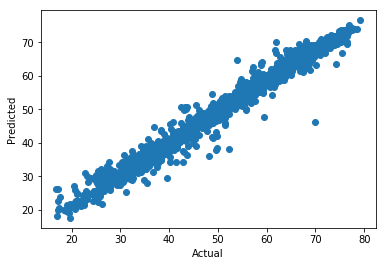

Max error:  23.590006734535194


In [23]:
plt.scatter(actual, predictions); plt.xlabel('Actual'); plt.ylabel('Predicted'); plt.show()
print('Max error: ', np.max(np.abs(actual - predictions)))

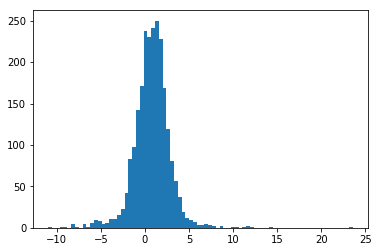

In [24]:
plt.hist(actual - predictions, bins = 80); plt.show()

In [17]:
import sklearn

sklearn.metrics.r2_score(predictions, actual)

0.9720815239861504

In [18]:
np.corrcoef(predictions, actual)

array([[1.       , 0.9916774],
       [0.9916774, 1.       ]])